In [1]:
from data_loader import Dataset

d = Dataset("data.json")
dataset = d.get_data("daewoo")
df = dataset["Steel_industry_data"]

In [2]:
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [3]:
week_status = {}
day_number = {}

for i, s in enumerate(df.WeekStatus.unique()):
    week_status[s] = 0 if i == 1 else 1

for i, d in enumerate(df.Day_of_week.unique()):
    day_number[d] = i + 1

In [4]:
df_copy = df[["date", "Day_of_week", "WeekStatus", "NSM", "Leading_Current_Reactive_Power_kVarh", "Leading_Current_Power_Factor",
        "Lagging_Current_Reactive.Power_kVarh", "Lagging_Current_Power_Factor", "CO2(tCO2)", "Usage_kWh"]].copy()

df_copy.head()

,date,Day_of_week,WeekStatus,NSM,Leading_Current_Reactive_Power_kVarh,Leading_Current_Power_Factor,Lagging_Current_Reactive.Power_kVarh,Lagging_Current_Power_Factor,CO2(tCO2),Usage_kWh
0,01/01/2018 00:15,Monday,Weekday,900,0.0,100.0,2.95,73.21,0.0,3.17
1,01/01/2018 00:30,Monday,Weekday,1800,0.0,100.0,4.46,66.77,0.0,4.00
2,01/01/2018 00:45,Monday,Weekday,2700,0.0,100.0,3.28,70.28,0.0,3.24
3,01/01/2018 01:00,Monday,Weekday,3600,0.0,100.0,3.56,68.09,0.0,3.31
4,01/01/2018 01:15,Monday,Weekday,4500,0.0,100.0,4.50,64.72,0.0,3.82


In [5]:
import pandas as pd

df_copy["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y %H:%M")
df_copy.set_index("date", inplace=True)
df_copy.head()

,Day_of_week,WeekStatus,NSM,Leading_Current_Reactive_Power_kVarh,Leading_Current_Power_Factor,Lagging_Current_Reactive.Power_kVarh,Lagging_Current_Power_Factor,CO2(tCO2),Usage_kWh
date,,,,,,,,,
2018-01-01 00:15:00,Monday,Weekday,900,0.0,100.0,2.95,73.21,0.0,3.17
2018-01-01 00:30:00,Monday,Weekday,1800,0.0,100.0,4.46,66.77,0.0,4.00
2018-01-01 00:45:00,Monday,Weekday,2700,0.0,100.0,3.28,70.28,0.0,3.24
2018-01-01 01:00:00,Monday,Weekday,3600,0.0,100.0,3.56,68.09,0.0,3.31
2018-01-01 01:15:00,Monday,Weekday,4500,0.0,100.0,4.50,64.72,0.0,3.82


In [6]:
df_copy["Day_of_week"] = df_copy["Day_of_week"].apply(lambda x: day_number[x])
df_copy["WeekStatus"] = df_copy["WeekStatus"].apply(lambda x: week_status[x])

In [7]:
hourly_df = df_copy.resample('H').mean()

In [34]:
import os

plots_dir = "plots"
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

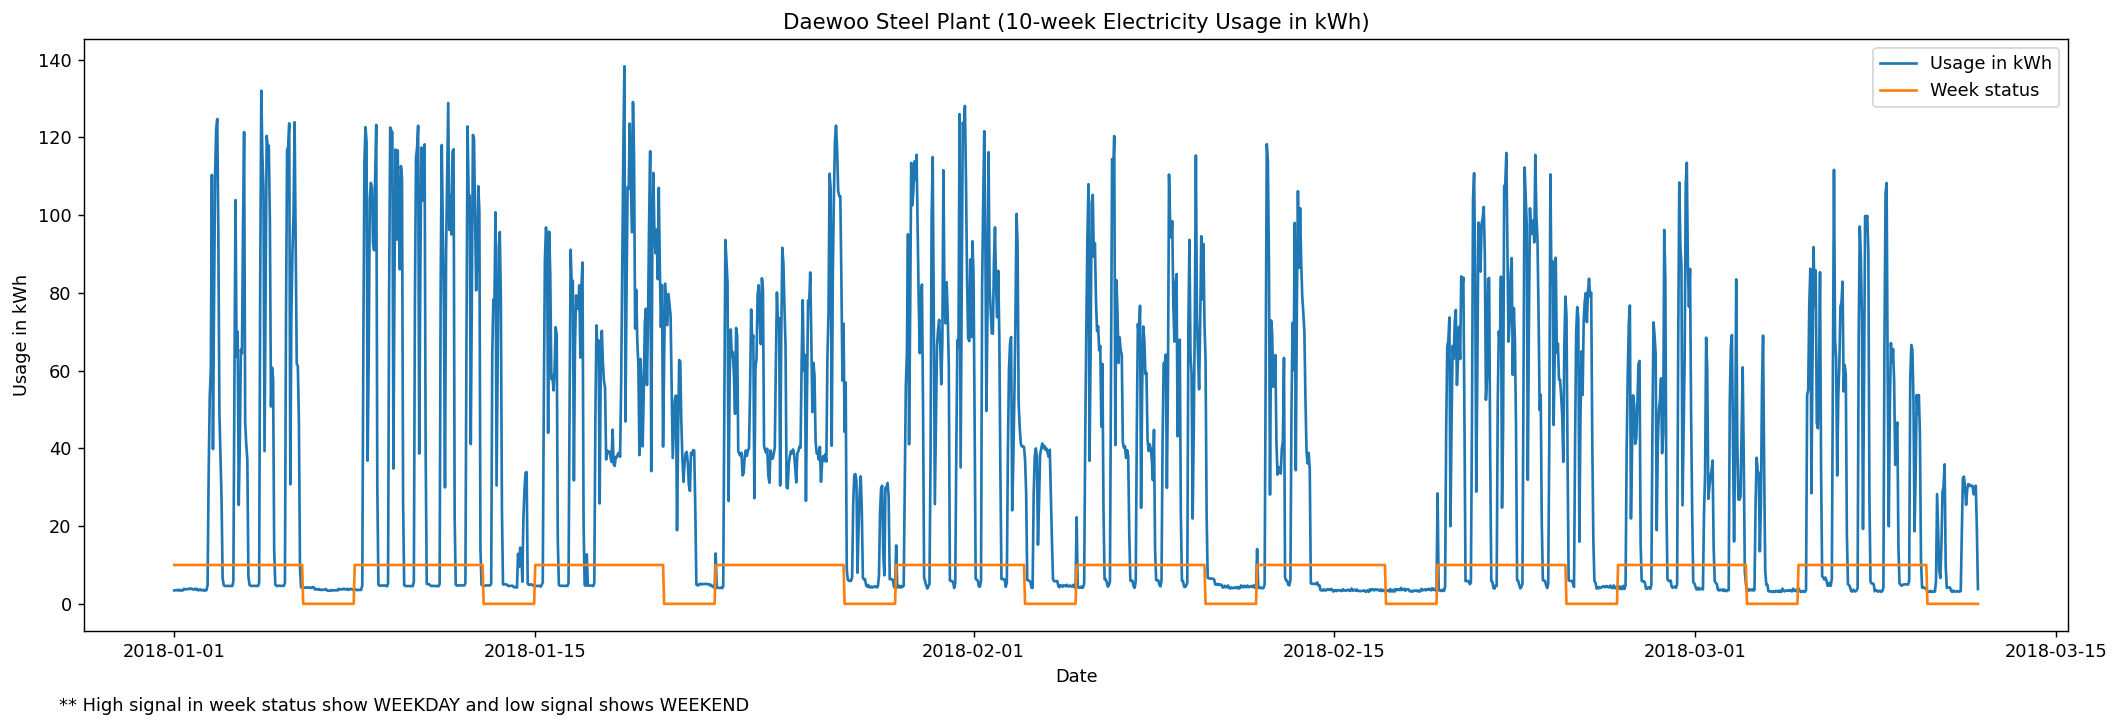

In [36]:
import matplotlib.pyplot as plt

n_weeks = 10
idx = int(n_weeks * 7 * 24)

plt.figure(figsize=(20, 6)).set_dpi(128)
plt.plot(hourly_df["Usage_kWh"].iloc[:idx], label="Usage in kWh")
#plt.plot(hourly_df["Day_of_week"].iloc[:idx] * 10, label="Day of week")
plt.plot(hourly_df["WeekStatus"].iloc[:idx] * 10, label="Week status")
plt.legend()

plt.xlabel("Date")
plt.ylabel("Usage in kWh")
plt.title("Daewoo Steel Plant (10-week Electricity Usage in kWh)")

fig = plt.gcf()  # Get current figure
note_text = "** High signal in week status show WEEKDAY and low signal shows WEEKEND"
x_center = 0.25  # Center of the plot in figure coordinates (0 to 1)
y_below_xlabel = 0  # Adjust this for note position relative to x-label
note = fig.text(x_center, y_below_xlabel, note_text, ha="center", va="bottom")

fname = f"{plots_dir}/10_week_usage_daewoo.png"
plt.savefig(fname, dpi=256, bbox_inches="tight")
plt.show()